# CS 271 CCSR

In [1]:
# Define imports
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import asarray
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import sys
import pickle
import os
import csv
from collections import defaultdict
import time
#
import re

## Step 1: Read in relevant Data Files

Make sure the filepaths below correspond to your local copies of the files

In [2]:
# Define constants
PATIENT_DATA_FILE = 'Data/B220_SAA_v1.csv'
CLEANED_LABELS_FILE = 'Data/ICD_Label_Cleaned_Oct_25.csv'
CODE_DESC_FILE = 'Data/BIODS220_ICD_Dx_10_9_v7 - icd_dx_10_9_v7.csv'
ICD10_to_CCSR = 'Data/ICD10-CCSR.csv'
LANG_MODEL = 'CCSR'

In [3]:
def read_csv_to_dict(file_path: str, key: int, value: int):
    ret_dict = {}
    with open(file_path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter=',')
        for row in data:
            ret_dict[row[key]] = row[value]
    print("Reading {} complete!".format(file_path))
    return ret_dict

In [4]:
def get_category_dict():
    category_dict = {
        'Circulatory': 0,
        'Dermatologic': 4,
        'Endocrine & Immune': 6,
        'Gastrointestinal': 1,
        'Genitourinary': 1, 
        'Hematologic': 4,
        'Infectious': 6,
        'Injury': 2,
        'Injury & Poisoning': 2,
        'Poisoning': 2,
        'Musculoskeletal': 2,
        'Neurologic': 3,
        'Other': 4,
        'Obstetric': 5,
        'Neoplastic': 4,
        'Psychiatric': 3,
        'Respiratory': 0,
        'Substance use': 2}
    #use to_categorical()
    return category_dict

In [5]:
NUM_CLASSES = 7

In [6]:
def get_label2className_dict():
    '''
    Function to create reverse map of labels to category name
    '''
    className_dict = {
        0:'Cardio-Resp',
        1:'Abdominal',
        2:'Injury/Subst/Poison', 
        3:'NeuroPsych',
        4:'Other',
        5:'Obstetric',
        6:'Infection-Immune'
    }
    #use to_categorical()
    return className_dict

In [7]:
# Create labels dict i.e. code -> label, i.e. A840 -> 'Neurologic'
label_dict = read_csv_to_dict(CLEANED_LABELS_FILE, key=0, value=1)

# Create descriptions dict i.e. code -> description
#codes_dict = read_csv_to_dict(CODE_DESC_FILE, key=0, value=2)

# Create mapping from ICD10 code to CCSR category
ccsr_dict = read_csv_to_dict(ICD10_to_CCSR, key=0, value=1)

# Create dict for label to int
category_dict = get_category_dict()

Reading Data/ICD_Label_Cleaned_Oct_25.csv complete!
Reading Data/ICD10-CCSR.csv complete!


## Step 2: Create one-hot feature vectors

First, let's take a look at the table of ICD10 codes to CCSR categories.

In [8]:
df = pd.read_csv(ICD10_to_CCSR, usecols=['ICD-10-CM Code','CCSR Category'])
df

,ICD-10-CM Code,CCSR Category
0,A000,DIG001
1,A000,INF003
2,A001,DIG001
3,A001,INF003
4,A009,DIG001
...,...,...
83452,Z9912,FAC012
83453,Z992,FAC025
83454,Z993,FAC025
83455,Z9981,FAC025


In [9]:
df.nunique()

ICD-10-CM Code    73205
CCSR Category       540
dtype: int64

We can see that we have over 83,000 ICD-10 codes that are assigned to one of 540 categories, significantly reducing the dimensionality of the data! We're next going to one hot encode each ICD-10 code into a vector of 540 entries, each corresponding to a particular CCSR category.

In [10]:
ccsr_one_hot = pd.get_dummies(df['CCSR Category']).to_numpy()
ccsr_one_hot.shape

(83457, 540)

ICD codes may map to more than one CCSR Category. In this case, we want to ensure that the one-hot encoding includes multiple CCSR categories. To accomplish this, we will create a dictionary that maps an ICD code to the corresponding 540-vector encoding. We should have 73,205 keys in the dictionary.

In [11]:
icd_to_ccsr = {} # Maps icd-10 code to ccsr category (which is 540-vector)

for i in range(len(ccsr_one_hot)):
    icd_code = df.iloc[i, 0] # 'A000'
    encoding = ccsr_one_hot[i,:] # one-hot encoding of size (540,)
    
    try:
        prev_encoding = icd_to_ccsr[icd_code]
        # if a previous encoding already exists, 
        # then we concatenate it with the one-hot encoding of the current category
        encoding = np.sum([prev_encoding, encoding], axis=0)
    except:
        pass
    
    icd_to_ccsr[icd_code] = encoding


Make sure we have one key per each unique ICD code. Thus, we are mapping every key to a (540,) one-hot encoding vector.

In [12]:
assert(len(icd_to_ccsr.keys()) == df['ICD-10-CM Code'].nunique())
ccsr_one_hot = None

For the sake of reducing feature space, we are only including three features in our embedding. Future iterations of our embeddings will include more features, such as the patient's county.

In [13]:
def create_one_hot(patient_data):
    # Creates one-hot vectors
    columns_to_one_hot = ['Sex','Race']
    one_hot = pd.get_dummies(patient_data[columns_to_one_hot])
    
    ordinal_columns = ['Age']
    one_hot = pd.concat([patient_data[ordinal_columns], one_hot], axis=1)
    
    # Normalize age
    x = one_hot.Age.values.reshape(-1,1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    one_hot.Age = x_scaled
    
    return one_hot.values

## Step 3: Create one-hot ICD code encoding

Given an ICD code, we retrieve the one hot encoding (540x1).

In [14]:
def code_to_embedding(code):
    try:
        embedding = icd_to_ccsr[code]
    except:
        print(code)
        return np.zeros(540)
    return embedding

For each row of ICD Codes (i.e ['E839', 'SA920']), we retrieve the corresponding embeddings. For patient visits with n ICD Codes where n>1, we give 0.75 weight to the primary ICD code and 0.25/n-1 weight to the remaining (secondary) codes.

In [15]:
def invalidCode(code):
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    return code[0] in numbers

In [16]:
def rowToEncoding(row):
    """
    input_row: A list of ICD10 codes
    returns a 540x1 embedding
    """
    patient_ICD_codes = [entry for entry in row[16:41] if entry != '']
    n = len(patient_ICD_codes)
    code = patient_ICD_codes[0]
    if invalidCode(code):
        print("Invalid primary code: ", code)
        return
    # Primary ICD code:
    primary_embedding = code_to_embedding(code)
    if n < 2: return primary_embedding
    
    # Subsequent ICD codes:
    secondary_embedding = None
    for i in range(1, n):
        code = patient_ICD_codes[i]
        if invalidCode(code):
            print("Invalid secondary code: ", code)
            continue
        curr_embed = code_to_embedding(code)
        if secondary_embedding is None:
            secondary_embedding = curr_embed
        else:
            secondary_embedding = np.sum([secondary_embedding, curr_embed], axis=0)
    
    
    return np.sum([primary_embedding, secondary_embedding], axis=0)

**Important:** Since a patient may have more than one ICD-10 code attributed to their visit to the emergency room, two or more codes may share the same CCSR category. Thus, when we take the sum of the CCSR one-hot encodings, we may end up with numbers greater than 1. Since we ultimately want the 540-vector encoding of the patient's visit to be a binary representation of the CCSR categories, numbers greater than 1 should be reduced to 1. This case will only occur when a patient comes in with more than one ICD_10 code that shares the same CCSR category, in which case we will be taking the sum of two identical one-hot encodings, producing something similar to [0, ..., 2, ...0].

We read in the patient visit csv file again and create embeddings for each visit as we read the file. For each visit, we have already computed the one-hot vector encoding for categorical and ordinal variables. Here, we combine those encodings with ICD_10 code embeddings. To reduce model complexity, we limit the number of patients (not total visits) for which to create embeddings. Here, we are working under the assumption that all visits for a patient appear one after the other in the csv file, thus. Takes a few mins to run

In [17]:
TOTAL_NUM_PATIENTS = .1e6

def get_visit_embedding(input_file_path: str): # input_file_path = PATIENT_DATA_FILE
    start_time = time.time()
    visit_encodings = []
    patient_visit = []
    with open(input_file_path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter=',')
        num_patients = 0
        first_row = True
        curr_patient_id = None
        
        for row in data:
            
            if first_row:
                first_row = False
                continue

            new_patient_id = row[0]
            
            # Used to limit num patients, reducing model space
            if curr_patient_id != new_patient_id:
                
                # If we have enough patients, break
                if num_patients >= TOTAL_NUM_PATIENTS:
                    break
                else:
                    curr_patient_id = new_patient_id
                    num_patients += 1
                    if num_patients % 20000 == 0:
                        print("Reading: ", num_patients, " patients")

            # Convert list of ICD-10 codes to 540-vector one-hot encoding
            code_embedding = rowToEncoding(row)
            visit_encodings.append(code_embedding)
            patient_visit.append([int(row[0]), int(row[1])]) # Store patient id and visit id
    
    # Reduce entries to be binary (0 or 1)
    code_dset = np.array(visit_encodings)
    min_arr = np.ones((len(code_dset), len(code_dset[0])))
    assert(min_arr.shape == code_dset.shape)
    code_dset = np.minimum(code_dset, min_arr)

    # Combine patient id, visit id and one-hot encoding
    visit_arr = np.array(patient_visit)
    result = np.hstack((visit_arr, code_dset)) # patient id, visit id, one-hot encoding vector
    return result

code_dset = get_visit_embedding(PATIENT_DATA_FILE)
num_visits = len(code_dset)
code_dset.shape

Reading:  20000  patients
Invalid secondary code:  129
Reading:  40000  patients
Reading:  60000  patients
Invalid secondary code:  1510
Reading:  80000  patients
Reading:  100000  patients


(628402, 542)

In [18]:
# Read in patient_data - takes about a minute
patient_read_start = time.time()
patient_data = pd.read_csv(PATIENT_DATA_FILE, dtype=str, usecols=['Sex','Race','Age','Dx10_prin'], nrows = num_visits)
print("Reading in patient_data took {}".format(time.time() - patient_read_start))

# One-hot encode visit features
one_hot_start = time.time()
one_hot_features = create_one_hot(patient_data)
print("Creating one-hot encodings took {}".format(time.time() - one_hot_start))
print(one_hot_features.shape)

Reading in patient_data took 0.894310712814331
Creating one-hot encodings took 0.21433305740356445
(628402, 11)


## Step 4: Concatenate Feature vector with ICD-10 code encoding

In [19]:
x_dset = np.hstack((code_dset, one_hot_features[:num_visits,:]))

In [20]:
x_dset.shape

(628402, 553)

## Step 5: Get labels

To create labels, we copy the primary diagnosis codes (`DX10_prin` column) into its own column named `Label`. For each code, we use the `label_dict` to retrive the corresponding category of the ICD code. Then we use the `category_dict` to retieve a number to represent the label. We limit the number of visits to the same size as the number of embeddings.

In [21]:
def convert_Dx10_prin_to_label(DX_10_code):
    try:
        category = label_dict[DX_10_code] # i.e. A065 -> Infectious
    except KeyError:
        category = 'Other'
    return category_dict[category] # i.e. Infectious -> 7 

def get_y_labels(patient_data):
    # Copy Dx10 code into new column named Label
    patient_data['Label'] = patient_data.Dx10_prin

    # Apply function to Label column to convert Dx10_prin code to category
    patient_data.Label = patient_data.Label.apply(convert_Dx10_prin_to_label)
    
    # Saves only the top num_visits, since that's how many embeddings there are
    y_list = patient_data.Label.iloc[:num_visits].to_list()
    return np.array(y_list), len(y_list)

In [22]:
# Get y_dset
label_start = time.time()
y_dset, num_labels = get_y_labels(patient_data)
print("Creating labels took {}".format(time.time() - label_start))

Creating labels took 0.35764598846435547


In [23]:
# Ensures the number of labels corresponds to the number of patient visits
assert(num_labels == num_visits)

## Step 6: Save embeddings and labels

In [24]:
filename = 'embeddings_{}.pickle'.format(LANG_MODEL)

start_time = time.time()
pickle_out = open(filename, 'wb')
pickle.dump((x_dset, y_dset), pickle_out, protocol=4)
pickle_out.close()
print("Saving embeddings took: {}".format(time.time() - start_time))

Saving embeddings took: 25.468826293945312


In [25]:
# filename = 'embeddings_{}.pickle'.format(LANG_MODEL)
# start_time = time.time()
# pickle_in = open(filename, 'rb')
# embedding_dset, y_dset = pickle.load(pickle_in)
# pickle_in.close()
# print("Saving embeddings took: {}".format(time.time() - start_time))

## Step 7: Store patient_id, visit_id, embedding_vec, label in a pandas dataframe

In [26]:
collated_data = np.hstack((x_dset, y_dset.reshape(y_dset.shape[0],1))) # -- last col is label column, first 2 are patient an visit ids
cols =  ['patient_id', 'visit_id'] + ['embed_vec'+ str(i) for i in range(x_dset.shape[1]-2)] + ['label']
df = pd.DataFrame(data = collated_data, columns = cols)

In [27]:
# Clear variables
collated_data = None
x_dset = None
y_dset = None

Transform the data types 

In [28]:
df['patient_id'] = df['patient_id'].astype('int64')
df['visit_id'] = df['visit_id'].astype('int64')
for col in cols[2:-1]:
    df[col] = df[col].astype(str).astype(np.float32)

df['label'] = df['label'].astype(np.int16)

In [29]:
df.dtypes

patient_id        int64
visit_id          int64
embed_vec0      float32
embed_vec1      float32
embed_vec2      float32
                 ...   
embed_vec547    float32
embed_vec548    float32
embed_vec549    float32
embed_vec550    float32
label             int16
Length: 554, dtype: object

Comment out the pickle dump/load sections below based on need

In [30]:
filename = 'patient_dataframe.pkl'
pickle_out = open(filename, 'wb')
pickle.dump(df, pickle_out, protocol=4)
pickle_out.close()

In [31]:
# filename = 'patient_dataframe.pkl'
# pickle_in = open(filename, 'rb')
# df = pickle.load(pickle_in)
# pickle_in.close()

In [32]:
df.head()

,patient_id,visit_id,embed_vec0,embed_vec1,embed_vec2,embed_vec3,embed_vec4,embed_vec5,embed_vec6,embed_vec7,...,embed_vec542,embed_vec543,embed_vec544,embed_vec545,embed_vec546,embed_vec547,embed_vec548,embed_vec549,embed_vec550,label
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
3,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
4,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


## Step 8: Data preprocessing: Create triplets of visits with labels using Sliding window approach

In [33]:
print("Number of patients: ", len(df['patient_id'].unique()))

Number of patients:  100000


In [34]:
# DATA PROCESSING
# RESHAPE INPUT TO THE DESIRED FORM FOR LSTM TRAINING:
# NEED 3D tensors of shape: [n_samples, n_timesteps = 2, n_features = input vector dim]

In [35]:
df = df.sort_values(['patient_id', 'visit_id'])
gf = df.groupby('patient_id')
data_X = []
data_Y = []
for patient in df['patient_id'].unique():
#     print(patient)
    curr_patient = gf.get_group(patient)
    num_visits  = curr_patient.shape[0]
    if num_visits < 3:
        continue
    elif num_visits == 3:
        visit_0 = list(curr_patient.iloc[0,2:-1].values)
        visit_1 = list(curr_patient.iloc[1,2:-1].values)
        data_X.append([visit_0, visit_1])
        data_Y.append(curr_patient.iloc[2,-1])
    else:
        for i in range(0, num_visits-2):
            visit_0 = list(curr_patient.iloc[i,2:-1].values)
            visit_1 = list(curr_patient.iloc[i+1,2:-1].values)
            data_X.append([visit_0, visit_1])
            data_Y.append(curr_patient.iloc[i+2,-1])

In [36]:
data_X = np.array(data_X)

In [37]:
data_Y = np.asarray(data_Y)

In [38]:
print(data_X.shape, data_Y.shape)
print(data_Y[100])

(428402, 2, 551) (428402,)
1


In [39]:
filename = 'data_X_data_Y.pkl'
pickle_out = open(filename, 'wb')
pickle.dump((data_X, data_Y), pickle_out, protocol=4)
pickle_out.close()

In [40]:
# filename = 'data_X_data_Y.pkl'
# pickle_in = open(filename, 'rb')
# data_X, data_Y = pickle.load(pickle_in)
# pickle_in.close()

## Step 9: Shuffle the data with correspoding labels and create train-val-test splits

- All examples are shuffled within a class. For training, intra- and inter-class shuffling happens and for val and test, no inter-class shuffling. 
-  Class balance is enforced for train,. val, test sets; Downside of the below approach for enforcing class balance is that not all examples are used and the bottleneck is the class which has the loweest fraction of the total examples

In [41]:
category_examples = []
for i in range(NUM_CLASSES):
#     print(i)
    category_examples.append(sum(data_Y==i))
for i, num in enumerate(category_examples):
    print(i , " : ", num)

0  :  80047
1  :  83446
2  :  95003
3  :  62818
4  :  55552
5  :  17520
6  :  34016


In [42]:
min_category_size = np.floor(min(category_examples))
min_train_classSize = int(0.95*min_category_size)
min_val_classSize = int(0.025*min_category_size)
total_examples  =  sum(category_examples)
print(min_train_classSize)

16644


In [43]:
# dictionary mapping class label to all its examples
examples = defaultdict(list)
for i in range(data_Y.shape[0]): 
    examples[data_Y[i]].append(data_X[i,:,:])
    
# shuffle examples of each class in place in the dictionary
for i in range(NUM_CLASSES):
    random.shuffle(examples[i]) 

In [44]:
# select min number of examples for the train set, val set and test set

train_X = examples[0][:min_train_classSize]
train_y = [0]*min_train_classSize
for i in range(1,NUM_CLASSES):
    train_X = np.vstack((train_X, examples[i][:min_train_classSize]))
    train_y+=[i]*min_train_classSize
train_X = np.array(train_X)
train_y = np.asarray(train_y)

val_X = examples[0][min_train_classSize:min_train_classSize + min_val_classSize]
val_y = [0]*min_val_classSize
for i in range(1,NUM_CLASSES):
    val_X = np.vstack((val_X, examples[i][min_train_classSize:min_train_classSize + min_val_classSize]))
    val_y+=[i]*min_val_classSize
val_X = np.array(val_X)
val_y = np.asarray(val_y)

test_X = examples[0][min_train_classSize + min_val_classSize : min_train_classSize + 2*min_val_classSize]
test_y = [0]*len(test_X)
for i in range(1,NUM_CLASSES):
    test_examples = examples[i][min_train_classSize + min_val_classSize : min_train_classSize + 2*min_val_classSize]
    test_X = np.vstack((test_X, test_examples))
    test_y+=[i]*len(test_examples)
test_X = np.array(test_X)
test_y = np.asarray(test_y)

In [45]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(116508, 2, 551) (116508,)
(3066, 2, 551) (3066,)
(3066, 2, 551) (3066,)


Convert integer y labels to one-hot vectors

In [46]:
train_y = tf.keras.utils.to_categorical(train_y, num_classes=NUM_CLASSES)
val_y = tf.keras.utils.to_categorical(val_y, num_classes=NUM_CLASSES)
test_y = tf.keras.utils.to_categorical(test_y, num_classes=NUM_CLASSES)

print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)


(116508, 2, 551) (116508, 7)
(3066, 2, 551) (3066, 7)
(3066, 2, 551) (3066, 7)


## Step 10: Create the model

In [47]:
BATCH_SIZE = 128
EPOCHS = 10
NUM_LSTM_UNITS = 300

In [48]:
# BUILD THE MODEL BY ADDING LAYERS
model = tf.keras.models.Sequential()

# add a bidirectional LSTM layer to not only take the past context of a vector into account but also the future context
# can play with the activation type here: tanh(default) or relu being popular options
# num_hidden_units
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = NUM_LSTM_UNITS,
#                                                              input_shape= (train_X.shape[1], train_X.shape[2])
#                                                             ), 
#                                                             merge_mode = 'sum'))
model.add(tf.keras.layers.LSTM(units = NUM_LSTM_UNITS,input_shape= (train_X.shape[1], train_X.shape[2])))
# model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=20, input_shape=(BATCH_SIZE,NUM_LSTM_UNITS),
#                                  padding = "valid", kernel_initializer = "glorot_uniform"))
# # we can add another Bidirectional LSTM layer if need be -- but we will need to evaluate that later -- no need rn
# model.add(Bidirectional(LSTM(num_hidden_units, input_shape= (train_X.shape[1], train_X.shape[2]))))

# add dense units
model.add(tf.keras.layers.Dense(units = 20, activation='relu'))
model.add(tf.keras.layers.Dense(units = 20, activation='relu'))

model.add(tf.keras.layers.Dense(units = NUM_CLASSES,
                                activity_regularizer = tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01), 
                                activation='softmax'))
# patient early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
# COMILE THE MODEL
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

## Step 11: Train the model

In [49]:
# TRAIN THE NETWORK
hist = model.fit(train_X, train_y, shuffle=True , epochs= EPOCHS,
                 batch_size = BATCH_SIZE, validation_data = (val_X, val_y)) 
# val data is not inter-class shuffled -- need not be  - bec evaluation is on entire val set

Epoch 1/10
911/911 [==============================] - 4s 5ms/step - loss: 1.5551 - accuracy: 0.4087 - val_loss: 1.5346 - val_accuracy: 0.4253
Epoch 2/10
911/911 [==============================] - 4s 4ms/step - loss: 1.4999 - accuracy: 0.4321 - val_loss: 1.5171 - val_accuracy: 0.4198
Epoch 3/10
911/911 [==============================] - 4s 4ms/step - loss: 1.4839 - accuracy: 0.4377 - val_loss: 1.5080 - val_accuracy: 0.4305
Epoch 4/10
911/911 [==============================] - 4s 4ms/step - loss: 1.4676 - accuracy: 0.4443 - val_loss: 1.5088 - val_accuracy: 0.4256
Epoch 5/10
911/911 [==============================] - 4s 4ms/step - loss: 1.4491 - accuracy: 0.4514 - val_loss: 1.5119 - val_accuracy: 0.4289
Epoch 6/10
911/911 [==============================] - 4s 4ms/step - loss: 1.4250 - accuracy: 0.4605 - val_loss: 1.5238 - val_accuracy: 0.4237
Epoch 7/10
911/911 [==============================] - 4s 4ms/step - loss: 1.3944 - accuracy: 0.4742 - val_loss: 1.5357 - val_accuracy: 0.4172
Epoch 

## Step 12: Evaluate the model

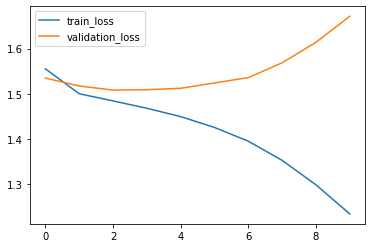

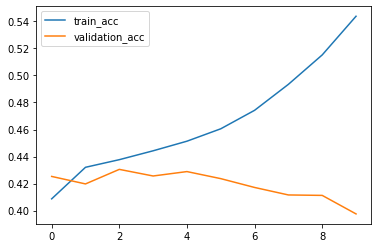

In [50]:
# PLOT HISTORY
plt.plot(hist.history['loss'], label = 'train_loss')
plt.plot(hist.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label = 'train_acc')
plt.plot(hist.history['val_accuracy'], label = 'validation_acc')
plt.legend()
plt.show()

In [51]:
# PRINT THE STATS
avg_train_acc = np.average(hist.history['accuracy'][9:])*100
avg_valid_acc = np.average(hist.history['val_accuracy'][9:])*100
print("Average training acc: ", avg_train_acc)
print("Average validation acc: ", avg_valid_acc)

Average training acc:  54.378241300582886
Average validation acc:  39.75864350795746


In [52]:
# EVALUATE THE MODEL
results = model.evaluate(test_X, test_y)
print("test loss, test acc:", results)

96/96 [==============================] - 0s 3ms/step - loss: 1.6694 - accuracy: 0.3995
test loss, test acc: [1.6694380044937134, 0.3995433747768402]


## Step 13: Predict based on the model and Visualize Output

In [53]:
from sklearn.metrics import confusion_matrix

# VARIABLES USED FOR MODEL SAVING, EVALUATING AND PLOTTING
label2className = get_label2className_dict() # dictionary to map numerical categories to their names : eg {1:"injury", 2:"endocrine"}

In [54]:
# make predictions
test_ypred = model.predict(test_X)
test_ypred = np.argmax(test_ypred, axis=-1)

In [55]:
print(test_ypred.shape)

(3066,)


In [56]:
import itertools  
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    pp = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0, fontsize=12)
    plt.yticks(tick_marks, class_names, fontsize=12)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color, fontsize = 15, weight="bold")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20, fontweight='bold')
    plt.xlabel('Predicted label', fontsize=20, fontweight='bold') 
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.1, left=.25)
    return figure

['Cardio-Resp', 'Abdominal', 'Injury/Subst/Poison', 'NeuroPsych', 'Other', 'Obstetric', 'Infection-Immune']


<Figure size 432x288 with 0 Axes>

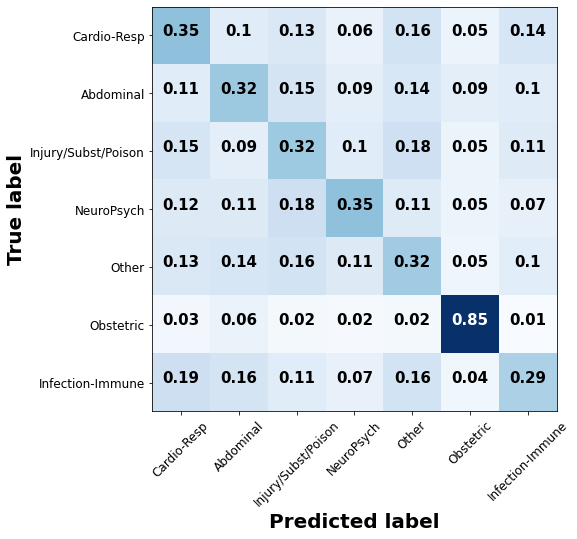

In [57]:
# VISUALIZE PREDICTIVE CAPACITY USING CONFUSION MATRICES
cm = confusion_matrix(np.argmax(test_y, axis=-1), test_ypred)
np.set_printoptions(precision=2)
plt.figure()

class_names = []
for k,v in label2className.items():
    class_names.append(v)
print(class_names)
plot_confusion_matrix(cm, class_names)
plt.savefig('Confusion_matrix_model_{}.png'.format(1))
plt.show()